# Standard CSP pipelines

This notebook implements multiple standard CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the experimental notebooks four to five are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Same subject, same session
   - Same subject, same session: LDA classifier 
   - Same subject, same session: SVM classifier 
   - Same subject, same session: RF classifier 
- Same subject, new session
   - Same subject, new session: LDA classifier
   - Same subject, new session: SVM classifier
   - Same subject, new session: RF classifier
- New subject
   - New subject: LDA classifier
   - New subject: SVM classifier
   - New subject: RF classifier
- Getting favourable results with CSP
   - Same session evaluation with favourable results
   - New session evaluation with favourable results
- Cleaning residual notebook variables

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

MNE version (1.0.2 recommended): 1.0.2
Scikit-learn version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Matplotlib version (3.5.1 recommended): 3.5.1
Pickle version (4.0 recommended): 4.0


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
We do this for three different traditional machine learning classifiers: linear discriminant analysis (LDA), support vector machines (SVM) and random forest (RF).
K-nearest neighbour (KNN) is not considered as it is too time-consuming in predictions and complex models such as a multilayer perceptron (MLP) are not considered either as they are an integral part of the deep learning models considered in later notebooks.

<hr>

### Same subject, same session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                                |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------------|
| B           | 0.6693 +- 0.02981                        | 0.6146                             | 4 CSP components \| SVM RBF with C 0.1 and Gamma auto     |
| C           | 0.7262 +- 0.0298                         | 0.7448                             | 6 CSP components \| SVM RBF with C 100 and Gamma 0.001    |
| E           | 0.7356 +- 0.0159                         | 0.7016                             | 6 CSP components \| SVM sigmoid with C 100 and Gamma 0.01 |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 6]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [0.1, 100, 100]
best_found_svm_gamma = ["auto", 0.001, 0.01]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only half a second window taking into account that the online system will use sliding windows.
      - This window starts at 0.1 seconds after the visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies of 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> RF
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csprf_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.6588 +- 0.0316                         | 0.6042                             | 4 CSP components \| RF max depth 10, max features 0.4, min sample split 10, 50 estimators    |
| C           | 0.7119 +- 0.0316                         | 0.7031                             | 6 CSP components \| RF max depth 3, max features 0.4, min sample split 5, 250 estimators     |
| E           | 0.7251 +- 0.0176                         | 0.7539                             | 10 CSP components \| RF max depth None, max features 0.2, min sample split 2, 250 estimators |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csprf_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 6 , 10]
best_found_rf_depth = [10, 3, None]
best_found_rf_max_featues = [0.4, 0.4, 0.2]
best_found_rf_min_sample = [10, 5, 2]
best_found_rf_n_estimators = [50, 250, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csprf_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del f
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy


<hr><hr>

## Same subject, new session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, but by using one or more sessions for training and testing on a new, unseen session.
This is a harder task than the previous one, where training and testing were done for the same session.
This section will train the same classifiers for the same participants as before but by using the first two datasets as training data and the third and final session of each participant as a standalone test set which is not used in training.



<hr>

### Same subject, new session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

Reading 0 ... 729399  =      0.000 ...  3646.995 secs...
Reading 0 ... 667399  =      0.000 ...  3336.995 secs...
Reading 0 ... 667799  =      0.000 ...  3338.995 secs...
Using data from preloaded Raw for 1918 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 35 candidates, totalling 210 fits
Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Using data from preloaded Raw for 1920 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 35 candidates, totalling 210 fits
Reading 0 ... 663999  =      0.000 ...  3319.995 secs...
Reading 0 ... 664399  =      0.000 ...  3321.995 secs...
Reading 0 ... 666999  =      0.000 ...  3334.995 secs...
Using data from preloaded Raw for 1917 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 35 candidates, totalling 210 fits


#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                   |
|-------------|------------------------------------------|------------------------------------|----------------------------------------------|
| B           | 0.4500 +- 0.02576                        | 0.4677                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| C           | 0.8177 +- 0.01940                        | 0.3587                             | CSP 10 components \| SVD LDA with 0.0001 tol |
| E           | 0.5525 +- 0.03678                        | 0.5518                             | CSP 10 components \| SVD LDA with 0.0001 tol |

In [7]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csplda.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.44997061128526644 with parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
34,5.325965,0.107249,0.004832,0.000373,10,eigen,NaN,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508761,0.501252,0.515019,0.484053,0.494059,0.503548,0.011883
24,5.413773,0.036873,0.004332,0.000471,10,svd,0.00007,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508135,0.503129,0.515019,0.484053,0.494059,0.503757,0.011803
23,5.456924,0.048601,0.004832,0.000373,10,svd,0.0004,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508135,0.503129,0.515019,0.484053,0.494059,0.503757,0.011803
22,5.481582,0.074412,0.005499,0.000764,10,svd,0.001,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508135,0.503129,0.515019,0.484053,0.494059,0.503757,0.011803
21,5.435931,0.068638,0.004832,0.000687,10,svd,0.00001,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508135,0.503129,0.515019,0.484053,0.494059,0.503757,0.011803
20,5.407107,0.060543,0.004499,0.000500,10,svd,0.0001,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508135,0.503129,0.515019,0.484053,0.494059,0.503757,0.011803
33,5.501247,0.045590,0.004832,0.000373,10,lsqr,NaN,0.4625,0.459375,0.434375,...,0.025761,1,0.518148,0.508761,0.501252,0.515019,0.484053,0.494059,0.503548,0.011883
32,5.401942,0.043255,0.003166,0.000373,6,eigen,NaN,0.4500,0.403125,0.406250,...,0.019975,8,0.482478,0.487484,0.447434,0.482478,0.464665,0.454659,0.469867,0.015221
31,5.401275,0.045625,0.003333,0.000472,6,lsqr,NaN,0.4500,0.403125,0.406250,...,0.019975,8,0.482478,0.487484,0.447434,0.482478,0.464665,0.454659,0.469867,0.015221
19,5.377282,0.043226,0.003499,0.000500,6,svd,0.00007,0.4500,0.403125,0.403125,...,0.020556,10,0.481852,0.487484,0.447434,0.481852,0.464665,0.454659,0.469658,0.015050




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
12,5.369285,0.046170,0.003332,0.000471,4,svd,0.001,0.428125,0.44375,0.365625,...,0.033162,22,0.426783,0.449937,0.419274,0.427409,0.434647,0.437148,0.432533,0.009694
29,5.413272,0.059934,0.003332,0.000471,4,lsqr,NaN,0.428125,0.44375,0.365625,...,0.033162,22,0.426783,0.449937,0.418648,0.428035,0.434647,0.437148,0.432533,0.009787
30,5.397610,0.065022,0.003332,0.000471,4,eigen,NaN,0.428125,0.44375,0.365625,...,0.033162,22,0.426783,0.449937,0.418648,0.428035,0.434647,0.437148,0.432533,0.009787
25,5.402943,0.036143,0.002499,0.000500,2,lsqr,NaN,0.390625,0.45625,0.396875,...,0.044478,29,0.429912,0.439925,0.386108,0.373592,0.419012,0.432770,0.413553,0.024874
26,5.390612,0.048714,0.002499,0.000500,2,eigen,NaN,0.390625,0.45625,0.396875,...,0.044478,29,0.429912,0.439925,0.386108,0.373592,0.419012,0.432770,0.413553,0.024874
1,5.622225,0.041098,0.002331,0.000470,2,svd,0.00001,0.390625,0.45625,0.396875,...,0.044021,31,0.429912,0.439925,0.386108,0.373592,0.419637,0.432770,0.413657,0.024898
3,5.546569,0.043613,0.002166,0.000373,2,svd,0.0004,0.390625,0.45625,0.396875,...,0.044021,31,0.429912,0.439925,0.386108,0.373592,0.419637,0.432770,0.413657,0.024898
4,5.536681,0.070654,0.002166,0.000372,2,svd,0.00007,0.390625,0.45625,0.396875,...,0.044021,31,0.429912,0.439925,0.386108,0.373592,0.419637,0.432770,0.413657,0.024898
2,5.489227,0.057258,0.002333,0.000471,2,svd,0.001,0.390625,0.45625,0.396875,...,0.044021,31,0.429912,0.439925,0.386108,0.373592,0.419637,0.432770,0.413657,0.024898
0,5.790951,0.083763,0.002333,0.000471,2,svd,0.0001,0.390625,0.45625,0.396875,...,0.044021,31,0.429912,0.439925,0.386108,0.373592,0.419637,0.432770,0.413657,0.024898




In total there are 35 different configurations tested.
The best mean test score is 0.45
There are 7 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,7.000000,7.000000,7.000000,7.000000,7.0,7,5.00000,7.000000e+00,7.000000e+00,7.000000e+00,...,7.000000e+00,7.0,7.000000,7.000000,7.000000,7.000000,7.000000e+00,7.000000e+00,7.000000,7.000000
unique,NaN,NaN,NaN,NaN,1.0,3,5.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.00007,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,5,1.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.431790,0.063129,0.004808,0.000506,NaN,NaN,NaN,4.625000e-01,4.593750e-01,4.343750e-01,...,2.576118e-02,1.0,0.518148,0.508314,0.502593,0.515019,4.840525e-01,4.940588e-01,0.503697,0.011826
std,0.057858,0.023519,0.000365,0.000160,NaN,NaN,NaN,5.995890e-17,5.995890e-17,5.995890e-17,...,7.494862e-18,0.0,0.000000,0.000305,0.000916,0.000000,5.995890e-17,5.995890e-17,0.000102,0.000039
min,5.325965,0.036873,0.004332,0.000373,NaN,NaN,NaN,4.625000e-01,4.593750e-01,4.343750e-01,...,2.576118e-02,1.0,0.518148,0.508135,0.501252,0.515019,4.840525e-01,4.940588e-01,0.503548,0.011803
25%,5.410440,0.047096,0.004665,0.000373,NaN,NaN,NaN,4.625000e-01,4.593750e-01,4.343750e-01,...,2.576118e-02,1.0,0.518148,0.508135,0.502190,0.515019,4.840525e-01,4.940588e-01,0.503653,0.011803
50%,5.435931,0.060543,0.004832,0.000471,NaN,NaN,NaN,4.625000e-01,4.593750e-01,4.343750e-01,...,2.576118e-02,1.0,0.518148,0.508135,0.503129,0.515019,4.840525e-01,4.940588e-01,0.503757,0.011803
75%,5.469253,0.071525,0.004832,0.000593,NaN,NaN,NaN,4.625000e-01,4.593750e-01,4.343750e-01,...,2.576118e-02,1.0,0.518148,0.508448,0.503129,0.515019,4.840525e-01,4.940588e-01,0.503757,0.011843





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8177083333333334 with parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
34,5.372951,0.073962,0.004665,0.000472,10,eigen,NaN,0.815625,0.7875,0.853125,...,0.019404,1,0.828125,0.8350,0.831875,0.828125,0.843125,0.836875,0.833854,0.005259
24,5.443928,0.036729,0.004832,0.000373,10,svd,0.00007,0.815625,0.7875,0.853125,...,0.019404,1,0.827500,0.8350,0.831875,0.828125,0.843125,0.836875,0.833750,0.005376
23,5.451259,0.055908,0.004665,0.000472,10,svd,0.0004,0.815625,0.7875,0.853125,...,0.019404,1,0.827500,0.8350,0.831875,0.828125,0.843125,0.836875,0.833750,0.005376
22,5.451593,0.051584,0.004665,0.000471,10,svd,0.001,0.815625,0.7875,0.853125,...,0.019404,1,0.827500,0.8350,0.831875,0.828125,0.843125,0.836875,0.833750,0.005376
21,5.456924,0.071654,0.004832,0.000373,10,svd,0.00001,0.815625,0.7875,0.853125,...,0.019404,1,0.827500,0.8350,0.831875,0.828125,0.843125,0.836875,0.833750,0.005376
20,5.426434,0.043945,0.004499,0.000500,10,svd,0.0001,0.815625,0.7875,0.853125,...,0.019404,1,0.827500,0.8350,0.831875,0.828125,0.843125,0.836875,0.833750,0.005376
33,5.458590,0.059358,0.005332,0.000942,10,lsqr,NaN,0.815625,0.7875,0.853125,...,0.019404,1,0.828125,0.8350,0.831875,0.828125,0.843125,0.836875,0.833854,0.005259
32,5.425934,0.062461,0.003332,0.000471,6,eigen,NaN,0.800000,0.7500,0.840625,...,0.026983,8,0.806875,0.8225,0.805000,0.808750,0.811250,0.815000,0.811562,0.005838
31,5.436431,0.059140,0.003499,0.000764,6,lsqr,NaN,0.800000,0.7500,0.840625,...,0.026983,8,0.806875,0.8225,0.805000,0.808750,0.811250,0.815000,0.811562,0.005838
19,5.399942,0.064668,0.003333,0.000471,6,svd,0.00007,0.800000,0.7500,0.840625,...,0.026983,8,0.806875,0.8225,0.805000,0.808750,0.811250,0.815000,0.811562,0.005838




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
3,5.422935,0.050707,0.002499,4.997651e-04,2,svd,0.0004,0.793750,0.740625,0.809375,...,0.022438,22,0.780,0.793750,0.783750,0.788750,0.798125,0.787500,0.788646,0.005999
4,5.401108,0.049301,0.002499,7.636033e-04,2,svd,0.00007,0.793750,0.740625,0.809375,...,0.022438,22,0.780,0.793750,0.783750,0.788750,0.798125,0.787500,0.788646,0.005999
0,5.388612,0.044534,0.002666,7.454265e-04,2,svd,0.0001,0.793750,0.740625,0.809375,...,0.022438,22,0.780,0.793750,0.783750,0.788750,0.798125,0.787500,0.788646,0.005999
5,5.416604,0.052432,0.002166,3.721891e-04,3,svd,0.0001,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.799375,0.784375,0.795625,0.794375,0.789375,0.791354,0.005548
27,5.410772,0.058162,0.002332,4.715110e-04,3,lsqr,NaN,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.800000,0.784375,0.795000,0.794375,0.789375,0.791354,0.005630
28,5.412604,0.053445,0.002999,1.123916e-07,3,eigen,NaN,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.800000,0.784375,0.795000,0.794375,0.789375,0.791354,0.005630
6,5.415437,0.061769,0.002333,4.713142e-04,3,svd,0.00001,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.799375,0.784375,0.795625,0.794375,0.789375,0.791354,0.005548
7,5.395943,0.049596,0.003332,1.246938e-03,3,svd,0.001,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.799375,0.784375,0.795625,0.794375,0.789375,0.791354,0.005548
8,5.387613,0.055018,0.002499,5.001228e-04,3,svd,0.0004,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.799375,0.784375,0.795625,0.794375,0.789375,0.791354,0.005548
9,5.403441,0.068141,0.002666,4.713145e-04,3,svd,0.00007,0.790625,0.737500,0.815625,...,0.023576,29,0.785,0.799375,0.784375,0.795625,0.794375,0.789375,0.791354,0.005548




In total there are 35 different configurations tested.
The best mean test score is 0.8177
There are 7 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,14.000000,14.000000,14.000000,14.000000,14.0,14,10.00000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
unique,NaN,NaN,NaN,NaN,2.0,3,5.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.00007,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,10,2.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.427005,0.055739,0.004130,0.000520,NaN,NaN,NaN,0.807813,0.768750,0.846875,...,0.023194,4.500000,0.817277,0.828750,0.818437,0.818437,0.827187,0.825937,0.822671,0.005590
std,0.024907,0.012719,0.000707,0.000151,NaN,NaN,NaN,0.008107,0.019458,0.006486,...,0.003932,3.632122,0.010796,0.006486,0.013945,0.010053,0.016539,0.011350,0.011528,0.000260
min,5.372951,0.034784,0.003332,0.000373,NaN,NaN,NaN,0.800000,0.750000,0.840625,...,0.019404,1.000000,0.806875,0.822500,0.805000,0.808750,0.811250,0.815000,0.811562,0.005259
25%,5.411355,0.045855,0.003499,0.000471,NaN,NaN,NaN,0.800000,0.750000,0.840625,...,0.019404,1.000000,0.806875,0.822500,0.805000,0.808750,0.811250,0.815000,0.811562,0.005376
50%,5.426184,0.059249,0.004082,0.000472,NaN,NaN,NaN,0.807813,0.768750,0.846875,...,0.023194,4.500000,0.817187,0.828750,0.818438,0.818437,0.827187,0.825937,0.822656,0.005607
75%,5.449426,0.064116,0.004665,0.000500,NaN,NaN,NaN,0.815625,0.787500,0.853125,...,0.026983,8.000000,0.827500,0.835000,0.831875,0.828125,0.843125,0.836875,0.833750,0.005838





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5524637539184952 with parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
24,5.404738,0.047325,0.004666,0.000471,10,svd,0.00007,0.487500,0.531250,0.565625,...,0.036775,1,0.569818,0.583594,0.572949,0.558824,0.576971,0.561952,0.570685,0.008456
23,5.414544,0.053654,0.004666,0.000471,10,svd,0.0004,0.487500,0.531250,0.565625,...,0.036775,1,0.569818,0.583594,0.572949,0.558824,0.576971,0.561952,0.570685,0.008456
22,5.423074,0.018591,0.005165,0.000373,10,svd,0.001,0.487500,0.531250,0.565625,...,0.036775,1,0.569818,0.583594,0.572949,0.558824,0.576971,0.561952,0.570685,0.008456
21,5.443097,0.061504,0.004832,0.000373,10,svd,0.00001,0.487500,0.531250,0.565625,...,0.036775,1,0.569818,0.583594,0.572949,0.558824,0.576971,0.561952,0.570685,0.008456
20,5.403401,0.065638,0.004833,0.000372,10,svd,0.0001,0.487500,0.531250,0.565625,...,0.036775,1,0.569818,0.583594,0.572949,0.558824,0.576971,0.561952,0.570685,0.008456
34,5.356239,0.100794,0.004661,0.000473,10,eigen,NaN,0.487500,0.531250,0.565625,...,0.036625,6,0.569192,0.583594,0.571697,0.558198,0.576971,0.561952,0.570267,0.008569
33,5.434308,0.052510,0.004665,0.000471,10,lsqr,NaN,0.487500,0.531250,0.565625,...,0.036625,6,0.569192,0.583594,0.571697,0.558198,0.576971,0.561952,0.570267,0.008569
19,5.386089,0.042491,0.005498,0.004715,6,svd,0.00007,0.459375,0.484375,0.496875,...,0.036737,8,0.517846,0.538510,0.512837,0.514393,0.512516,0.530038,0.521023,0.009836
18,5.388858,0.038988,0.003499,0.000500,6,svd,0.0004,0.459375,0.484375,0.496875,...,0.036737,8,0.517846,0.538510,0.512837,0.514393,0.512516,0.530038,0.521023,0.009836
16,5.391821,0.041460,0.003332,0.000471,6,svd,0.00001,0.459375,0.484375,0.496875,...,0.036737,8,0.517846,0.538510,0.512837,0.514393,0.512516,0.530038,0.521023,0.009836




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
5,5.396208,0.064162,0.002499,4.995666e-04,3,svd,0.0001,0.3750,0.459375,0.478125,...,0.036877,22,0.472761,0.479649,0.479649,0.432416,0.491865,0.436170,0.465418,0.022741
28,5.384392,0.064971,0.002833,3.724556e-04,3,eigen,NaN,0.3750,0.456250,0.478125,...,0.036647,27,0.472761,0.479023,0.479649,0.432416,0.492491,0.436170,0.465418,0.022800
27,5.385055,0.035717,0.002666,4.714547e-04,3,lsqr,NaN,0.3750,0.456250,0.478125,...,0.036647,27,0.472761,0.479023,0.479649,0.432416,0.492491,0.436170,0.465418,0.022800
2,5.382403,0.035026,0.002166,3.726688e-04,2,svd,0.001,0.3125,0.406250,0.453125,...,0.048248,29,0.433312,0.428929,0.432060,0.436796,0.441176,0.438048,0.435054,0.004062
25,5.383334,0.041997,0.002000,1.820952e-07,2,lsqr,NaN,0.3125,0.406250,0.453125,...,0.048248,29,0.432686,0.428929,0.432060,0.436170,0.441802,0.438673,0.435054,0.004320
1,5.373709,0.053912,0.003166,1.343046e-03,2,svd,0.00001,0.3125,0.406250,0.453125,...,0.048248,29,0.433312,0.428929,0.432060,0.436796,0.441176,0.438048,0.435054,0.004062
3,5.392224,0.078592,0.002333,4.711456e-04,2,svd,0.0004,0.3125,0.406250,0.453125,...,0.048248,29,0.433312,0.428929,0.432060,0.436796,0.441176,0.438048,0.435054,0.004062
4,5.374064,0.041719,0.002666,4.712300e-04,2,svd,0.00007,0.3125,0.406250,0.453125,...,0.048248,29,0.433312,0.428929,0.432060,0.436796,0.441176,0.438048,0.435054,0.004062
26,5.370033,0.051684,0.002333,1.698825e-03,2,eigen,NaN,0.3125,0.406250,0.453125,...,0.048248,29,0.432686,0.428929,0.432060,0.436170,0.441802,0.438673,0.435054,0.004320
0,5.394867,0.043142,0.002499,4.997255e-04,2,svd,0.0001,0.3125,0.406250,0.453125,...,0.048248,29,0.433312,0.428929,0.432060,0.436796,0.441176,0.438048,0.435054,0.004062




In total there are 35 different configurations tested.
The best mean test score is 0.5525
There are 5 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,7.000000,7.000000,7.000000,7.000000,7.0,7,5.00000,7.000000e+00,7.00000,7.000000e+00,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000e+00,7.000000,7.000000
unique,NaN,NaN,NaN,NaN,1.0,3,5.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.00007,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,5,1.00000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.411343,0.057145,0.004784,0.000429,NaN,NaN,NaN,4.875000e-01,0.53125,5.656250e-01,...,0.036732,2.428571,0.569640,0.583594,0.572591,0.558645,0.576971,5.619524e-01,0.570566,0.008488
std,0.028363,0.024539,0.000186,0.000053,NaN,NaN,NaN,5.995890e-17,0.00000,1.199178e-16,...,0.000073,2.439750,0.000306,0.000000,0.000611,0.000305,0.000000,1.199178e-16,0.000204,0.000055
min,5.356239,0.018591,0.004661,0.000372,NaN,NaN,NaN,4.875000e-01,0.53125,5.656250e-01,...,0.036625,1.000000,0.569192,0.583594,0.571697,0.558198,0.576971,5.619524e-01,0.570267,0.008456
25%,5.404070,0.049918,0.004665,0.000373,NaN,NaN,NaN,4.875000e-01,0.53125,5.656250e-01,...,0.036700,1.000000,0.569505,0.583594,0.572323,0.558511,0.576971,5.619524e-01,0.570476,0.008456
50%,5.414544,0.053654,0.004666,0.000471,NaN,NaN,NaN,4.875000e-01,0.53125,5.656250e-01,...,0.036775,1.000000,0.569818,0.583594,0.572949,0.558824,0.576971,5.619524e-01,0.570685,0.008456
75%,5.428691,0.063571,0.004832,0.000471,NaN,NaN,NaN,4.875000e-01,0.53125,5.656250e-01,...,0.036775,3.500000,0.569818,0.583594,0.572949,0.558824,0.576971,5.619524e-01,0.570685,0.008512





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.46770833333333334


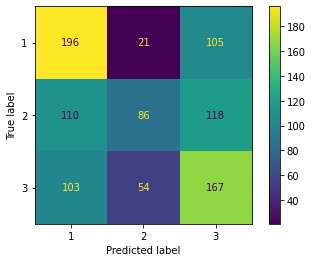

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


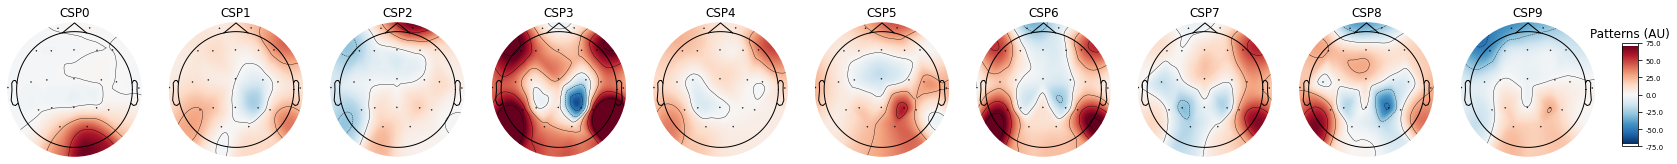




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3587069864442127


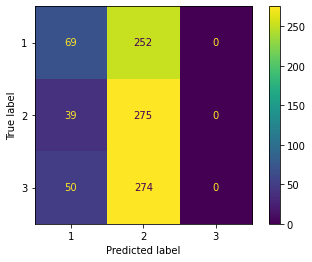

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


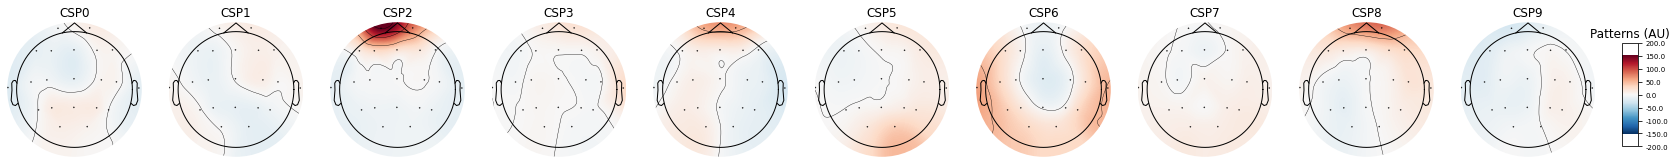




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.5518324607329843


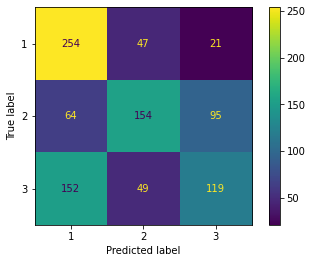

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


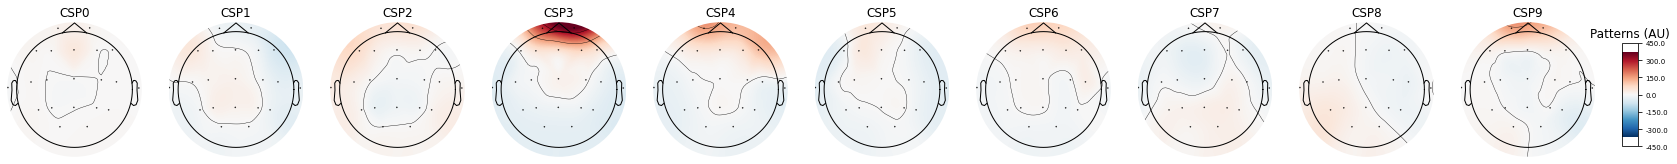

In [9]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The C: 0.01 | 0.1 | 1 | 10 | 100
            - The kernel: rbf | sigmoid | linear
            - When using the rbf of sigmoid kernel, the gamma: scale | auto | 10 | 1 | 0.1 | 0.01 | 0.001
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limited computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

Reading 0 ... 729399  =      0.000 ...  3646.995 secs...
Reading 0 ... 667399  =      0.000 ...  3336.995 secs...
Reading 0 ... 667799  =      0.000 ...  3338.995 secs...
Using data from preloaded Raw for 1918 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 225 candidates, totalling 1350 fits
Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Using data from preloaded Raw for 1920 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 225 candidates, totalling 1350 fits
Reading 0 ... 663999  =      0.000 ...  3319.995 secs...
Reading 0 ... 664399  =      0.000 ...  3321.995 secs...
Reading 0 ... 666999  =      0.000 ...  3334.995 secs...
Using data from preloaded Raw for 1917 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 225 candidates, totalling 1350 

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + SVM: cross validation accuracy** | **CSP + SVM: test split accuracy** | **Config**                                             |
|-------------|------------------------------------------|------------------------------------|--------------------------------------------------------|
| B           | 0.4625 +- 0.0276                         | 0.4677                             | 10 CSP components \| rbf SVM with C 10 and gamma 0.01  |
| C           | 0.8338 +- 0.0213                         | 0.3754                             | 10 CSP components \| rbf SVM with C 1 and gamma auto   |
| E           | 0.5816 +- 0.0255                         | 0.3895                             | 10 CSP components \| rbf SVM with C 1 and gamma scale  |

In [8]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_cspsvm.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.46248857105538144 with parameters
{'CSP__n_components': 10, 'SVM__C': 10, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
192,5.568229,0.063741,0.054359,0.004185,10,10,0.01,rbf,0.481250,0.462500,...,0.027577,1,0.532541,0.514393,0.505632,0.526909,0.505316,0.495935,0.513454,0.012784
208,5.555005,0.064429,0.053316,0.001699,10,100,0.001,rbf,0.465625,0.453125,...,0.027582,2,0.528160,0.509387,0.504380,0.513141,0.495935,0.490932,0.506989,0.012101
224,6.946046,0.085665,0.013663,0.001490,10,100,NaN,linear,0.456250,0.453125,...,0.035536,3,0.531289,0.505006,0.496871,0.513767,0.490306,0.489681,0.504487,0.014623
223,5.712160,0.093627,0.013874,0.000405,10,10,NaN,linear,0.453125,0.456250,...,0.035536,3,0.531289,0.507509,0.496871,0.514393,0.488430,0.489681,0.504696,0.015058
222,5.512335,0.057571,0.014495,0.000957,10,1,NaN,linear,0.456250,0.453125,...,0.033869,5,0.534418,0.505632,0.492491,0.513767,0.490932,0.490932,0.504695,0.015782
221,5.527065,0.066557,0.014496,0.000957,10,0.1,NaN,linear,0.459375,0.456250,...,0.033994,6,0.530038,0.506884,0.500000,0.511264,0.495310,0.490932,0.505738,0.012801
209,5.585397,0.078837,0.021660,0.001490,10,100,0.001,sigmoid,0.459375,0.456250,...,0.033994,6,0.530663,0.506884,0.500000,0.510013,0.495935,0.490932,0.505738,0.012839
206,5.600729,0.075998,0.054316,0.003543,10,100,0.01,rbf,0.468750,0.425000,...,0.027705,8,0.554443,0.533792,0.541302,0.540676,0.533458,0.522201,0.537645,0.009795
178,5.528270,0.085942,0.054982,0.002645,10,1,0.01,rbf,0.481250,0.456250,...,0.029547,9,0.523154,0.505632,0.495620,0.506258,0.490932,0.494684,0.502713,0.010743
170,5.515809,0.097320,0.055316,0.001247,10,1,auto,rbf,0.456250,0.425000,...,0.026014,10,0.566333,0.538798,0.545056,0.541302,0.534084,0.529706,0.542547,0.011720




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
21,5.556853,0.094353,0.023493,0.001707,4,0.1,1,sigmoid,0.296875,0.312500,...,0.020845,216,0.287860,0.317272,0.282854,0.279725,0.285178,0.322076,0.295827,0.017095
159,5.541945,0.099997,0.019994,0.000577,10,0.1,10,sigmoid,0.303125,0.318750,...,0.016170,217,0.265332,0.298498,0.280976,0.284105,0.305191,0.286429,0.286755,0.012762
103,5.508948,0.091336,0.016995,0.001633,6,1,10,sigmoid,0.259375,0.325000,...,0.021060,218,0.289737,0.312265,0.279099,0.318523,0.292683,0.298937,0.298541,0.013402
47,5.486405,0.066430,0.016661,0.001598,4,10,10,sigmoid,0.268750,0.271875,...,0.024305,219,0.287860,0.271589,0.280976,0.319775,0.276423,0.322076,0.293117,0.020275
91,5.567795,0.061089,0.025658,0.000942,6,0.1,1,sigmoid,0.296875,0.278125,...,0.012310,220,0.288486,0.304130,0.282228,0.280350,0.278299,0.317699,0.291865,0.014369
161,5.620501,0.103255,0.029324,0.001374,10,0.1,1,sigmoid,0.300000,0.275000,...,0.012355,221,0.290989,0.270964,0.277847,0.289111,0.303315,0.303315,0.289257,0.011994
61,5.504968,0.055060,0.016661,0.001105,4,100,10,sigmoid,0.268750,0.271875,...,0.023402,222,0.287860,0.270964,0.280976,0.319149,0.276423,0.322702,0.293012,0.020402
33,5.499028,0.090676,0.016828,0.001213,4,1,10,sigmoid,0.265625,0.271875,...,0.024798,223,0.290363,0.267209,0.282854,0.318523,0.275797,0.320200,0.292491,0.020251
19,5.530873,0.085733,0.019660,0.001490,4,0.1,10,sigmoid,0.268750,0.306250,...,0.012291,224,0.278473,0.264706,0.286608,0.311014,0.272045,0.313321,0.287694,0.018530
89,5.538276,0.091236,0.018661,0.001598,6,0.1,10,sigmoid,0.262500,0.268750,...,0.023116,225,0.284731,0.289111,0.275344,0.278473,0.293934,0.272045,0.282273,0.007701




In total there are 225 different configurations tested.
The best mean test score is 0.4625
There are 1 configurations with this maximum score
There are 12 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,12.000000,12.000000,12.000000,12.000000,12.0,12.0,8.00,12,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
unique,NaN,NaN,NaN,NaN,1.0,4.0,4.00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,100.0,0.01,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,12.0,4.0,4.00,6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.681793,0.076658,0.035399,0.001759,NaN,NaN,NaN,NaN,0.462240,0.448177,...,0.030853,6.083333,0.538277,0.514758,0.510117,0.520338,0.503961,0.500573,0.514671,0.012779
std,0.401739,0.015399,0.020002,0.001184,NaN,NaN,NaN,NaN,0.010012,0.014193,...,0.003774,3.315483,0.015063,0.013794,0.020643,0.013412,0.018542,0.016270,0.016083,0.001751
min,5.512335,0.053502,0.013663,0.000373,NaN,NaN,NaN,NaN,0.453125,0.425000,...,0.026014,1.000000,0.523154,0.504380,0.492491,0.506258,0.488430,0.489681,0.502713,0.009795
25%,5.527968,0.064257,0.014496,0.000957,NaN,NaN,NaN,NaN,0.456250,0.446094,...,0.027581,3.000000,0.530507,0.505632,0.496871,0.511264,0.490932,0.490932,0.504696,0.011720
50%,5.561617,0.077418,0.037488,0.001490,NaN,NaN,NaN,NaN,0.457812,0.454688,...,0.031210,6.000000,0.531289,0.507196,0.500000,0.513767,0.495622,0.491245,0.505738,0.012792
75%,5.589230,0.087863,0.054327,0.002247,NaN,NaN,NaN,NaN,0.466406,0.456250,...,0.033994,9.250000,0.539424,0.519243,0.514549,0.530350,0.512351,0.502502,0.519502,0.013693





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8338541666666667 with parameters
{'CSP__n_components': 10, 'SVM__C': 1, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
170,5.465572,0.048488,0.030657,0.000942,10,1,auto,rbf,0.837500,0.806250,...,0.021303,1,0.855000,0.853125,0.851250,0.844375,0.864375,0.858125,0.854375,0.006134
176,5.503598,0.048057,0.031324,0.000942,10,1,0.1,rbf,0.837500,0.806250,...,0.021303,1,0.855000,0.853125,0.851250,0.844375,0.864375,0.858125,0.854375,0.006134
168,5.448316,0.043673,0.029990,0.000816,10,1,scale,rbf,0.840625,0.800000,...,0.018170,3,0.874375,0.870625,0.869375,0.857500,0.880625,0.868750,0.870208,0.006957
192,5.440268,0.065889,0.029324,0.001247,10,10,0.01,rbf,0.828125,0.793750,...,0.021607,4,0.840625,0.843125,0.839375,0.831875,0.851250,0.846250,0.842083,0.006002
206,5.447359,0.053554,0.026159,0.000687,10,100,0.01,rbf,0.837500,0.800000,...,0.017647,5,0.859375,0.855625,0.851875,0.843750,0.865625,0.853125,0.854896,0.006735
154,5.475635,0.060550,0.043653,0.001374,10,0.1,scale,rbf,0.834375,0.803125,...,0.024324,6,0.835000,0.851250,0.843750,0.823125,0.848750,0.845000,0.841146,0.009523
184,5.450008,0.049254,0.027158,0.002733,10,10,auto,rbf,0.840625,0.784375,...,0.024766,7,0.890625,0.886250,0.871250,0.870000,0.887500,0.880000,0.880937,0.007953
190,5.449612,0.059454,0.028657,0.004817,10,10,0.1,rbf,0.840625,0.784375,...,0.024766,7,0.890625,0.886250,0.871250,0.870000,0.887500,0.880000,0.880937,0.007953
221,5.440358,0.062691,0.010497,0.000764,10,0.1,NaN,linear,0.825000,0.781250,...,0.021092,9,0.829375,0.838125,0.834375,0.823750,0.843750,0.841250,0.835104,0.006879
223,5.502102,0.066761,0.009330,0.000745,10,10,NaN,linear,0.815625,0.781250,...,0.021399,9,0.825625,0.839375,0.835625,0.825625,0.851250,0.846875,0.837396,0.009712




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
10,5.501662,0.042406,0.051650,0.000745,4,0.01,0.01,rbf,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
12,5.498958,0.082246,0.053861,0.002197,4,0.01,0.001,rbf,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
82,5.487833,0.079256,0.053316,0.000745,6,0.01,0.001,rbf,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
13,5.448689,0.054929,0.018161,0.000373,4,0.01,0.001,sigmoid,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
96,5.534901,0.058348,0.053150,0.000373,6,0.1,0.001,rbf,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
81,5.487553,0.062595,0.019161,0.000372,6,0.01,0.01,sigmoid,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
97,5.510097,0.058802,0.018994,0.000578,6,0.1,0.001,sigmoid,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
27,5.477552,0.058636,0.018827,0.002409,4,0.1,0.001,sigmoid,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
11,5.490853,0.042248,0.020327,0.004345,4,0.01,0.01,sigmoid,0.337500,0.33750,...,5.551115e-17,202,0.3375,0.337500,0.337500,0.337500,0.3375,0.337500,0.337500,5.551115e-17
19,5.521237,0.092961,0.020827,0.002671,4,0.1,10,sigmoid,0.384375,0.46875,...,8.082823e-02,225,0.3650,0.399375,0.265625,0.215625,0.2750,0.373125,0.315625,6.696839e-02




In total there are 225 different configurations tested.
The best mean test score is 0.8339
There are 2 configurations with this maximum score
There are 26 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,26.000000,26.000000,26.000000,2.600000e+01,26.0,26.0,21.00,26,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
unique,NaN,NaN,NaN,NaN,1.0,5.0,6.00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,10.0,0.01,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,26.0,8.0,6.00,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.477356,0.059524,0.027154,1.673842e-03,NaN,NaN,NaN,NaN,0.822476,0.791106,...,0.019908,12.692308,0.847716,0.852187,0.848413,0.838173,0.859880,0.855096,0.850244,0.007584
std,0.069465,0.010608,0.013542,1.671689e-03,NaN,NaN,NaN,NaN,0.011892,0.010372,...,0.003035,7.556556,0.031903,0.026965,0.024916,0.029282,0.024856,0.025193,0.027044,0.001589
min,5.431840,0.043673,0.008540,7.240322e-07,NaN,NaN,NaN,NaN,0.796875,0.775000,...,0.014254,1.000000,0.823125,0.830625,0.829375,0.812500,0.839375,0.835625,0.828750,0.004152
25%,5.447602,0.051378,0.013246,7.449866e-04,NaN,NaN,NaN,NaN,0.815625,0.781250,...,0.017514,7.000000,0.827500,0.836406,0.834375,0.822188,0.843750,0.840313,0.834193,0.006714
50%,5.455959,0.058473,0.028598,9.711213e-04,NaN,NaN,NaN,NaN,0.821875,0.793750,...,0.020578,11.500000,0.830000,0.839063,0.837813,0.825313,0.849375,0.845625,0.837708,0.007953
75%,5.484652,0.062394,0.039154,1.673418e-03,NaN,NaN,NaN,NaN,0.832812,0.799219,...,0.021998,19.000000,0.858281,0.855000,0.851719,0.844375,0.865312,0.858125,0.854766,0.008785





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5816434822361546 with parameters
{'CSP__n_components': 10, 'SVM__C': 1, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
168,5.482249,0.029599,0.050150,0.001950,10,1,scale,rbf,0.568750,0.546875,...,0.025547,1,0.663745,0.673763,0.653726,0.660826,0.670839,0.657697,0.663433,0.007019
206,5.616039,0.059804,0.048818,0.002266,10,100,0.01,rbf,0.578125,0.550000,...,0.035902,2,0.632436,0.647464,0.619912,0.638298,0.634543,0.634543,0.634533,0.008160
176,5.504242,0.047538,0.049484,0.001117,10,1,0.1,rbf,0.559375,0.537500,...,0.029201,3,0.639950,0.652473,0.633688,0.642053,0.642678,0.636421,0.641210,0.005928
170,5.488913,0.047904,0.049317,0.002134,10,1,auto,rbf,0.559375,0.537500,...,0.029201,3,0.639950,0.652473,0.633688,0.642053,0.642678,0.636421,0.641210,0.005928
154,5.508740,0.065091,0.055316,0.002494,10,0.1,scale,rbf,0.531250,0.562500,...,0.022409,5,0.602379,0.626800,0.605510,0.615144,0.615144,0.603254,0.611372,0.008637
192,5.513239,0.031337,0.049651,0.001105,10,10,0.01,rbf,0.553125,0.546875,...,0.029420,6,0.611772,0.618660,0.607389,0.607009,0.613892,0.599499,0.609704,0.006039
162,5.516238,0.034486,0.056316,0.002493,10,0.1,0.1,rbf,0.509375,0.568750,...,0.026863,7,0.577959,0.614277,0.601127,0.589487,0.595119,0.586984,0.594159,0.011474
156,5.518404,0.058280,0.058315,0.002285,10,0.1,auto,rbf,0.509375,0.568750,...,0.026863,7,0.577959,0.614277,0.601127,0.589487,0.595119,0.586984,0.594159,0.011474
190,5.503409,0.045187,0.046318,0.001795,10,10,0.1,rbf,0.562500,0.562500,...,0.013333,9,0.697558,0.701315,0.700063,0.695244,0.693992,0.681477,0.694941,0.006532
184,5.517238,0.039345,0.046985,0.001000,10,10,auto,rbf,0.562500,0.562500,...,0.013333,9,0.697558,0.701315,0.700063,0.695244,0.693992,0.681477,0.694941,0.006532




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
47,5.462255,0.066934,0.018328,0.000943,4,10,10,sigmoid,0.309375,0.281250,...,0.066304,215,0.278647,0.288666,0.393863,0.283479,0.285357,0.296621,0.304439,0.040364
33,6.413369,0.119142,0.019494,0.001708,4,1,10,sigmoid,0.309375,0.278125,...,0.067198,217,0.278647,0.286788,0.395116,0.282228,0.284731,0.296621,0.304022,0.041111
29,5.460122,0.053549,0.016828,0.001950,4,1,scale,sigmoid,0.262500,0.306250,...,0.036929,218,0.296807,0.300564,0.417032,0.287234,0.299124,0.304130,0.317482,0.044822
19,5.495521,0.033737,0.018661,0.000745,4,0.1,10,sigmoid,0.309375,0.281250,...,0.052732,219,0.279274,0.292423,0.385097,0.280976,0.285982,0.294118,0.302978,0.037122
57,5.498077,0.058346,0.017828,0.002671,4,100,scale,sigmoid,0.253125,0.306250,...,0.043852,220,0.302442,0.303694,0.420789,0.288486,0.295369,0.302253,0.318839,0.045897
21,5.525791,0.046490,0.021494,0.001708,4,0.1,1,sigmoid,0.293750,0.293750,...,0.046362,221,0.277395,0.284283,0.377583,0.285982,0.285357,0.292866,0.300578,0.034730
43,5.450592,0.040709,0.015662,0.000745,4,10,scale,sigmoid,0.253125,0.300000,...,0.043362,222,0.298059,0.302442,0.421415,0.287860,0.309136,0.299750,0.319777,0.045890
49,5.556558,0.046089,0.020827,0.001343,4,10,1,sigmoid,0.287500,0.290625,...,0.041935,223,0.273012,0.286162,0.401378,0.285982,0.287860,0.291615,0.304335,0.043777
63,5.492245,0.055231,0.020494,0.001384,4,100,1,sigmoid,0.287500,0.287500,...,0.043702,224,0.273638,0.293676,0.400751,0.284731,0.288486,0.291615,0.305483,0.043092
35,5.905614,0.185749,0.021659,0.001885,4,1,1,sigmoid,0.287500,0.290625,...,0.044103,225,0.273012,0.287414,0.400751,0.286608,0.284105,0.294118,0.304335,0.043573




In total there are 225 different configurations tested.
The best mean test score is 0.5816
There are 1 configurations with this maximum score
There are 10 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0,10,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,NaN,NaN,NaN,NaN,1.0,4.0,4.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,1.0,0.1,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,10.0,3.0,3.0,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.516871,0.045857,0.051067,0.001864,NaN,NaN,NaN,NaN,0.549375,0.554375,...,0.025207,5.200000,0.634126,0.650282,0.635629,0.637484,0.639800,0.630476,0.637966,0.007772
std,0.036875,0.012352,0.004094,0.000587,NaN,NaN,NaN,NaN,0.024242,0.012076,...,0.007145,2.859681,0.043221,0.033203,0.037963,0.038435,0.036747,0.035768,0.037295,0.002154
min,5.482249,0.029599,0.046318,0.001000,NaN,NaN,NaN,NaN,0.509375,0.537500,...,0.013333,1.000000,0.577959,0.614277,0.601127,0.589487,0.595119,0.586984,0.594159,0.005928
25%,5.503617,0.035700,0.048942,0.001287,NaN,NaN,NaN,NaN,0.536719,0.546875,...,0.023194,3.000000,0.604728,0.620695,0.605980,0.609043,0.614205,0.600438,0.610121,0.006162
50%,5.510989,0.046362,0.049568,0.002042,NaN,NaN,NaN,NaN,0.559375,0.556250,...,0.026863,5.500000,0.636193,0.649969,0.626800,0.640175,0.638611,0.635482,0.637872,0.006775
75%,5.516988,0.055686,0.054025,0.002280,NaN,NaN,NaN,NaN,0.562500,0.562500,...,0.029201,7.000000,0.657796,0.668441,0.648716,0.656133,0.663798,0.652378,0.657877,0.008518





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.46770833333333334


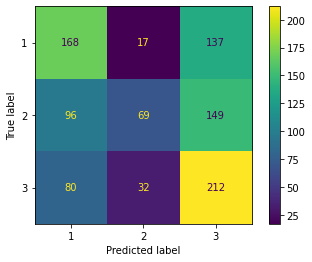

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


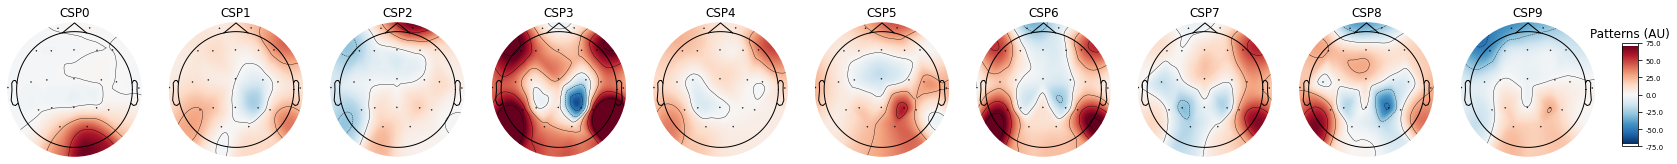




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3753910323253389


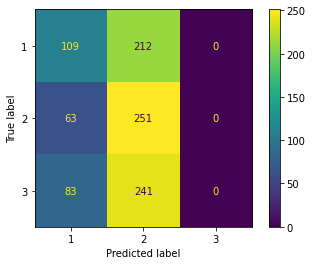

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


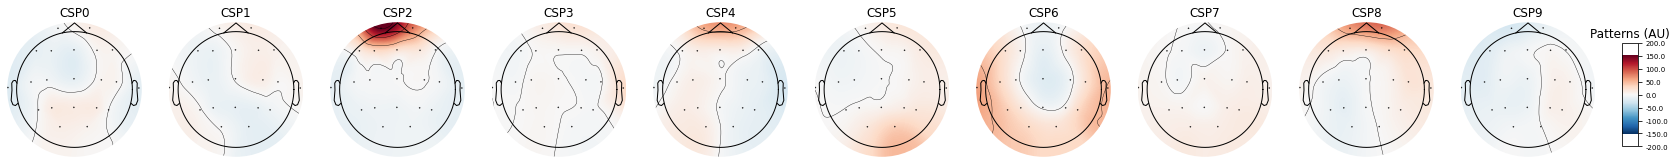




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.38952879581151834


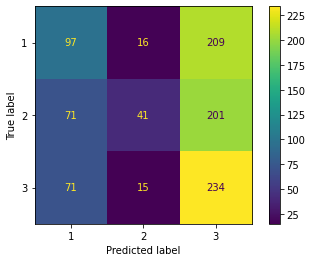

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


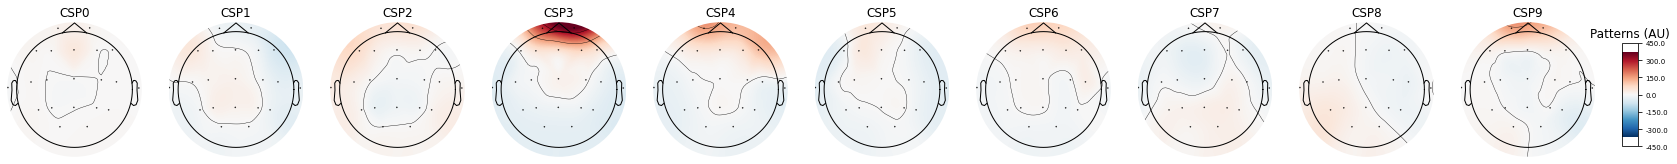

In [10]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_svm_kernel = ["rbf", "rbf", "sigmoid"]
best_found_svm_c = [10, 1, 1]
best_found_svm_gamma = [0.01, "auto", "scale"]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    svm = SVC(kernel= best_found_svm_kernel[i],
              C= best_found_svm_c[i],
              gamma= best_found_svm_gamma[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_svm_kernel
del best_found_svm_c
del best_found_svm_gamma
del i
del X_test
del y_test
del X_train
del y_train
del csp
del svm
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr>

### Same subject, new session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the first two recorded session of each of these participants for training and the last for testing.
      - Thus, the CV scores are on the test split for the training data whilst the independent test set is from the unseen session not used during training. This avoids data leakage.
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the created window of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For RF:
            - Bootstrap is always set to True as it is, besides random feature subsets, one of the ways to reduce data biases during training
            - The metric used for splitting criterion is gini as it is faster than entropy and the performance difference is negligible when looking at the experimental notebooks
            - Number of estimators: 10 | 50 | 100 | 250 | 500
            - Max depth of a tree: None | 3 | 10 | 20 | 35 | 50 | 75 | 100
            - Minimum number of samples to do a split: 2 | 5 | 10
            - Minimum samples to have a leaf is not set as it is related to the number of samples per split and max depth of the tree
            - Maximum features per tree: sqrt | log2 | None
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get all training data (all but last session of participant)
                mne_raws= CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_id)
                
                # Combine training data into singular mne raw
                mne_raw = mne.concatenate_raws(mne_raws)
                
                # Delete all raws since concat changes them
                del mne_raws
                
                # Get epochs for all those MNE raws (all training sessions)
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                  h_freq= filter_upper_bound,
                                  picks= "all",
                                  phase= "minimum",
                                  fir_window= "blackman",
                                  fir_design= "firwin",
                                  pad= 'median', 
                                  n_jobs= -1,
                                  verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                rf = RandomForestClassifier(bootstrap= True,
                                            criterion= "gini")
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('RF', rf)])
                
                # Configure cross validation to use, more splits then before since we have more data
                cv = StratifiedKFold(n_splits= 6,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [4, 6, 10],
                               "RF__n_estimators": [10, 50, 100, 250, 500],
                               "RF__max_depth": [None, 3, 10],
                               "RF__min_samples_split": [2, 5, 10],
                               "RF__max_features": ["sqrt", "log2", "None", 0.2, 0.4, 0.6]}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= mne_epochs_data, y= labels)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del rf
                del pipeline
                del labels
                del cv
                del file
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

Reading 0 ... 729399  =      0.000 ...  3646.995 secs...
Reading 0 ... 667399  =      0.000 ...  3336.995 secs...
Reading 0 ... 667799  =      0.000 ...  3338.995 secs...
Using data from preloaded Raw for 1918 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 810 candidates, totalling 4860 fits


C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\ensemble

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Reading 0 ... 681199  =      0.000 ...  3405.995 secs...
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Using data from preloaded Raw for 1920 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 810 candidates, totalling 4860 fits


C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\ensemble

Reading 0 ... 663999  =      0.000 ...  3319.995 secs...
Reading 0 ... 664399  =      0.000 ...  3321.995 secs...
Reading 0 ... 666999  =      0.000 ...  3334.995 secs...
Using data from preloaded Raw for 1917 events and 601 original time points ...
0 bad epochs dropped
Fitting 6 folds for each of 810 candidates, totalling 4860 fits


C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Lennert\.conda\envs\bci-master-thesis\lib\site-packages\sklearn\ensemble

#### Results

The CV results are based on the training set alone and thus only look at the first two sessions.
The test result is for a new, unseen session and thus scores are expected to differ.

| **Subject** | **CSP + RF: cross validation accuracy** | **CSP + RF: test split accuracy** | **Config**                                                                                   |
|-------------|-----------------------------------------|-----------------------------------|----------------------------------------------------------------------------------------------|
| B           | 0.4489 +- 0.0351                        | 0.4406                            | 10 CSP components \| RF with max depth 3, 0.4 features, 10 min sample split, 500 estimators  |
| C           | 0.8198 +- 0.0198                        | 0.3462                            | 10 CSP components \| RF with max depth None, 0.2 features, 2 min sample split, 50 estimators |
| E           | 0.5770 +- 0.0290                        | 0.4911                            | 10 CSP components \| RF with max depth 10, 0.4 features, 10 min sample split, 250 estimators |

In [5]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_differentsession/subject{subject_id}/gridsearch_csprf.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.44891751567398114 with parameters
{'CSP__n_components': 10, 'RF__max_depth': 3, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 500}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
704,6.288822,0.033622,0.055982,0.004508,10,3,0.4,10,500,0.475000,...,0.035137,1,0.540050,0.523154,0.516270,0.534418,0.519074,0.512195,0.524194,0.009916
647,5.473083,0.066109,0.014329,0.000471,10,3,log2,2,100,0.478125,...,0.035396,2,0.538798,0.543179,0.517522,0.546934,0.527205,0.522827,0.532744,0.010860
698,5.724003,0.024250,0.028991,0.000577,10,3,0.4,5,250,0.459375,...,0.031401,3,0.537547,0.520025,0.511890,0.537547,0.511570,0.519700,0.523046,0.010778
699,6.274327,0.054617,0.053983,0.000577,10,3,0.4,5,500,0.481250,...,0.030516,4,0.540050,0.516270,0.513767,0.534418,0.519074,0.517824,0.523567,0.009932
649,6.198851,0.051525,0.055316,0.001105,10,3,log2,2,500,0.478125,...,0.034705,5,0.550063,0.533792,0.513141,0.544431,0.529706,0.525954,0.532848,0.012091
690,5.215166,0.029022,0.005165,0.000372,10,3,0.4,2,10,0.481250,...,0.033004,6,0.521902,0.506884,0.505632,0.518773,0.503440,0.507192,0.510637,0.007023
648,5.705676,0.045883,0.031156,0.003974,10,3,log2,2,250,0.471875,...,0.032963,7,0.549437,0.535044,0.513767,0.532541,0.529081,0.523452,0.530554,0.010917
659,6.189020,0.022069,0.054316,0.000471,10,3,log2,10,500,0.481250,...,0.036880,8,0.543179,0.537547,0.511264,0.540050,0.534084,0.520325,0.531075,0.011446
693,5.727002,0.038843,0.029157,0.000687,10,3,0.4,2,250,0.471875,...,0.035690,9,0.537547,0.526909,0.516896,0.533792,0.518449,0.514697,0.524715,0.008686
702,5.392275,0.025105,0.014329,0.000471,10,3,0.4,10,100,0.456250,...,0.033377,10,0.541927,0.525031,0.516270,0.533166,0.527205,0.510944,0.525757,0.010234




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
489,5.310468,0.040122,0.0,0.0,6,10,None,5,500,NaN,...,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,5.201670,0.050766,0.0,0.0,6,10,None,2,50,NaN,...,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,5.258152,0.033508,0.0,0.0,6,3,None,10,250,NaN,...,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,5.203669,0.048178,0.0,0.0,6,3,None,10,100,NaN,...,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,5.189840,0.037868,0.0,0.0,6,3,None,10,50,NaN,...,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,5.218998,0.047122,0.0,0.0,6,3,None,10,10,NaN,...,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,5.432763,0.083974,0.0,0.0,6,3,None,5,500,NaN,...,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,5.278645,0.034963,0.0,0.0,6,3,None,5,250,NaN,...,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,5.166847,0.039080,0.0,0.0,6,10,None,2,10,NaN,...,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,5.323298,0.029294,0.0,0.0,6,3,None,10,500,NaN,...,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.4489
There are 1 configurations with this maximum score
There are 146 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,146.000000,146.000000,146.000000,1.460000e+02,146.0,137.0,146,146.0,146.0,146.000000,...,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
unique,NaN,NaN,NaN,NaN,2.0,2.0,5,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,3.0,sqrt,10.0,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,99.0,110.0,33,54.0,40.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.724071,0.043302,0.029333,1.110624e-03,NaN,NaN,NaN,NaN,NaN,0.457663,...,0.028474,73.452055,0.629155,0.628470,0.619550,0.623391,0.623022,0.622979,0.624428,0.008888
std,0.474131,0.011790,0.020131,1.325608e-03,NaN,NaN,NaN,NaN,NaN,0.012981,...,0.006108,42.313621,0.182232,0.185578,0.193853,0.193275,0.191195,0.191815,0.189502,0.003045
min,5.184343,0.018081,0.004999,1.777067e-07,NaN,NaN,NaN,NaN,NaN,0.428125,...,0.014030,1.000000,0.492491,0.493742,0.493742,0.472466,0.492183,0.490932,0.494264,0.000000
25%,5.345166,0.034625,0.013204,4.710965e-04,NaN,NaN,NaN,NaN,NaN,0.450000,...,0.024821,37.250000,0.512672,0.517522,0.505632,0.492491,0.507817,0.507817,0.506882,0.007276
50%,5.605790,0.042823,0.028574,5.771021e-04,NaN,NaN,NaN,NaN,NaN,0.456250,...,0.028377,73.500000,0.538486,0.527534,0.513454,0.531602,0.520325,0.517824,0.524662,0.009198
75%,6.027031,0.052105,0.053608,1.105207e-03,NaN,NaN,NaN,NaN,NaN,0.465625,...,0.033295,109.750000,0.561170,0.548811,0.533479,0.551783,0.544246,0.542839,0.541997,0.010892





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.8197916666666666 with parameters
{'CSP__n_components': 10, 'RF__max_depth': None, 'RF__max_features': 0.2, 'RF__min_samples_split': 2, 'RF__n_estimators': 50}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
586,5.468418,0.071404,0.014496,0.006549,10,None,0.2,2,50,0.818750,...,0.019819,1,0.999375,1.000000,1.000000,0.999375,1.000000,0.999375,0.999687,0.000312
558,6.179690,0.057260,0.036989,0.000817,10,None,log2,2,250,0.793750,...,0.026125,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
587,5.598710,0.043140,0.017828,0.001067,10,None,0.2,2,100,0.806250,...,0.018641,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
768,5.996082,0.053971,0.037821,0.004596,10,10,0.2,2,250,0.803125,...,0.019348,4,0.976250,0.981250,0.983750,0.981250,0.980625,0.983125,0.981042,0.002412
592,5.609207,0.054281,0.018494,0.000500,10,None,0.2,5,100,0.809375,...,0.019094,4,0.998125,0.995625,0.995000,0.996875,0.995000,0.994375,0.995833,0.001284
615,5.382945,0.069358,0.006498,0.000499,10,None,0.6,2,10,0.812500,...,0.025430,6,0.985625,0.988125,0.988750,0.991250,0.985000,0.991250,0.988333,0.002438
567,5.641696,0.029298,0.017495,0.000957,10,None,log2,10,100,0.803125,...,0.024122,7,0.960625,0.957500,0.962500,0.957500,0.960000,0.959375,0.959583,0.001755
774,6.660537,0.057995,0.066645,0.001598,10,10,0.2,5,500,0.800000,...,0.019073,7,0.970000,0.964375,0.971875,0.966875,0.970000,0.965625,0.968125,0.002676
781,5.485912,0.052559,0.011497,0.001258,10,10,0.4,2,50,0.796875,...,0.024788,9,0.979375,0.981250,0.983125,0.985000,0.983750,0.980000,0.982083,0.002031
738,6.136705,0.030369,0.036155,0.002339,10,10,log2,2,250,0.796875,...,0.022146,10,0.982500,0.985625,0.986875,0.983125,0.985000,0.983750,0.984479,0.001506




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
489,5.441760,0.072491,0.0,0.0,6,10,None,5,500,NaN,...,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,5.347956,0.050206,0.0,0.0,6,10,None,2,50,NaN,...,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,5.352288,0.050912,0.0,0.0,6,3,None,10,250,NaN,...,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
402,5.313301,0.061456,0.0,0.0,6,3,None,10,100,NaN,...,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,5.283144,0.054436,0.0,0.0,6,3,None,10,50,NaN,...,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
400,5.299139,0.065402,0.0,0.0,6,3,None,10,10,NaN,...,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
399,5.402773,0.034252,0.0,0.0,6,3,None,5,500,NaN,...,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,5.354954,0.058481,0.0,0.0,6,3,None,5,250,NaN,...,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,5.284477,0.053404,0.0,0.0,6,10,None,2,10,NaN,...,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,5.430597,0.048202,0.0,0.0,6,3,None,10,500,NaN,...,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.8198
There are 1 configurations with this maximum score
There are 129 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,129.000000,129.000000,129.000000,1.290000e+02,129.0,66.0,129.0,129.0,129.0,129.000000,...,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
unique,NaN,NaN,NaN,NaN,2.0,1.0,5.0,3.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,10.0,0.6,10.0,250.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,128.0,66.0,27.0,44.0,31.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.113911,0.055613,0.031845,1.764666e-03,NaN,NaN,NaN,NaN,NaN,0.796342,...,0.020744,63.620155,0.972611,0.971773,0.975426,0.973609,0.973324,0.973372,0.973353,0.002294
std,0.722545,0.021618,0.022401,1.986289e-03,NaN,NaN,NaN,NaN,NaN,0.007351,...,0.003154,37.547926,0.021050,0.023346,0.020466,0.021426,0.020719,0.021207,0.021251,0.001366
min,5.327130,0.024757,0.005665,4.298152e-07,NaN,NaN,NaN,NaN,NaN,0.771875,...,0.011219,1.000000,0.921875,0.921875,0.923125,0.924375,0.927500,0.928750,0.925312,0.000000
25%,5.567220,0.044128,0.011497,6.870479e-04,NaN,NaN,NaN,NaN,NaN,0.790625,...,0.018786,31.000000,0.961250,0.956250,0.962500,0.960000,0.960000,0.958750,0.960104,0.001284
50%,5.866124,0.052559,0.018494,9.996495e-04,NaN,NaN,NaN,NaN,NaN,0.796875,...,0.020963,60.000000,0.970000,0.972500,0.977500,0.975000,0.972500,0.973125,0.973542,0.002412
75%,6.632546,0.063156,0.039488,1.885214e-03,NaN,NaN,NaN,NaN,NaN,0.800000,...,0.022535,94.000000,0.995000,0.995625,0.995000,0.995000,0.994375,0.993750,0.994896,0.003256





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.5769674111807733 with parameters
{'CSP__n_components': 10, 'RF__max_depth': 10, 'RF__max_features': 0.4, 'RF__min_samples_split': 10, 'RF__n_estimators': 250}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
793,6.246836,0.058861,0.034156,0.000687,10,10,0.4,10,250,0.568750,...,0.029031,1,0.877270,0.869130,0.879148,0.870463,0.882353,0.862954,0.873553,0.006634
808,6.637710,0.042254,0.034489,0.000500,10,10,0.6,10,250,0.565625,...,0.026321,2,0.871634,0.867877,0.880401,0.866083,0.885482,0.867334,0.873135,0.007286
724,6.972770,0.058687,0.064813,0.000897,10,10,sqrt,2,500,0.559375,...,0.025288,3,0.947401,0.930495,0.940513,0.935544,0.944931,0.927409,0.937716,0.007266
743,6.102215,0.074741,0.035822,0.000687,10,10,log2,5,250,0.559375,...,0.022637,4,0.929242,0.908579,0.927990,0.913642,0.918648,0.912390,0.918415,0.007797
732,5.587380,0.017596,0.016161,0.000372,10,10,sqrt,10,100,0.546875,...,0.027574,5,0.876644,0.876018,0.871634,0.867334,0.884230,0.856696,0.872093,0.008596
554,7.116558,0.025470,0.068145,0.002192,10,None,sqrt,10,500,0.562500,...,0.018288,6,0.964934,0.973075,0.973075,0.966208,0.974343,0.974343,0.970996,0.003888
723,6.103382,0.068446,0.034822,0.000687,10,10,sqrt,2,250,0.571875,...,0.031380,6,0.948028,0.932999,0.942392,0.939925,0.944305,0.931790,0.939906,0.005846
731,5.417767,0.070397,0.010497,0.000764,10,10,sqrt,10,50,0.584375,...,0.019176,8,0.865999,0.854728,0.867877,0.855444,0.876095,0.854819,0.862494,0.008116
612,5.674352,0.039028,0.016995,0.000577,10,None,0.4,10,100,0.550000,...,0.027673,9,0.968065,0.962430,0.966813,0.963079,0.968711,0.966208,0.965884,0.002364
597,5.523401,0.029758,0.017161,0.000897,10,None,0.2,10,100,0.540625,...,0.019971,10,0.967439,0.959925,0.961177,0.955569,0.964330,0.958073,0.961086,0.003911




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
481,5.237825,0.057107,0.0,0.0,6,10,None,2,50,NaN,...,NaN,801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
482,5.240824,0.041455,0.0,0.0,6,10,None,2,100,NaN,...,NaN,802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,5.305137,0.061377,0.0,0.0,6,10,None,2,250,NaN,...,NaN,803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,5.373782,0.042392,0.0,0.0,6,10,None,2,500,NaN,...,NaN,804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,5.220998,0.057545,0.0,0.0,6,10,None,5,10,NaN,...,NaN,805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,5.243157,0.037571,0.0,0.0,6,10,None,5,50,NaN,...,NaN,806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,5.245656,0.056370,0.0,0.0,6,10,None,5,100,NaN,...,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
488,5.304970,0.031309,0.0,0.0,6,10,None,5,250,NaN,...,NaN,808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,5.309136,0.035426,0.0,0.0,6,3,None,5,250,NaN,...,NaN,809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
404,5.374615,0.049983,0.0,0.0,6,3,None,10,500,NaN,...,NaN,810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




In total there are 810 different configurations tested.
The best mean test score is 0.577
There are 1 configurations with this maximum score
There are 102 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_RF__max_depth,param_RF__max_features,param_RF__min_samples_split,param_RF__n_estimators,split0_test_score,...,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,mean_train_score,std_train_score
count,102.000000,102.000000,102.000000,1.020000e+02,102.0,59.0,102,102.0,102.0,102.000000,...,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
unique,NaN,NaN,NaN,NaN,1.0,2.0,5,3.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,10.0,log2,10.0,500.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,102.0,58.0,23,35.0,29.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.200793,0.049928,0.035069,1.463454e-03,NaN,NaN,NaN,NaN,NaN,0.546691,...,0.025157,51.411765,0.941060,0.935099,0.939537,0.934569,0.942594,0.933612,0.937745,0.004694
std,0.773970,0.013993,0.022639,1.754671e-03,NaN,NaN,NaN,NaN,NaN,0.013870,...,0.004430,29.567963,0.053956,0.055417,0.054273,0.056511,0.052175,0.058204,0.054939,0.003169
min,5.375115,0.017596,0.010163,3.276750e-07,NaN,NaN,NaN,NaN,NaN,0.506250,...,0.013656,1.000000,0.607389,0.636193,0.613024,0.622653,0.626408,0.608886,0.619092,0.000000
25%,5.561846,0.040449,0.016203,4.995765e-04,NaN,NaN,NaN,NaN,NaN,0.537500,...,0.022459,26.250000,0.915780,0.907952,0.914058,0.903786,0.919274,0.908010,0.911294,0.002060
50%,6.030488,0.051755,0.034656,7.636423e-04,NaN,NaN,NaN,NaN,NaN,0.546875,...,0.025190,51.500000,0.944584,0.929869,0.937383,0.934293,0.943054,0.930538,0.936203,0.005011
75%,6.689236,0.058965,0.064813,1.710333e-03,NaN,NaN,NaN,NaN,NaN,0.556250,...,0.027664,76.750000,0.987790,0.987007,0.988885,0.989831,0.990613,0.987484,0.988524,0.007244





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.440625


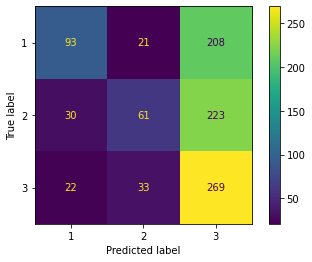

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


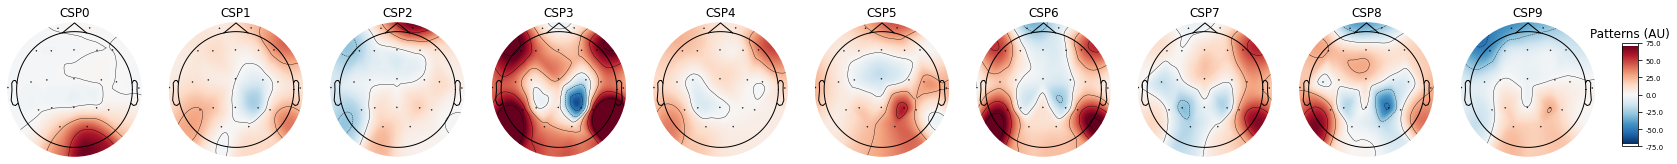




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.3461939520333681


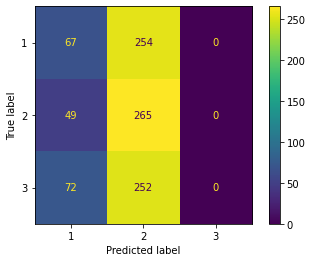

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


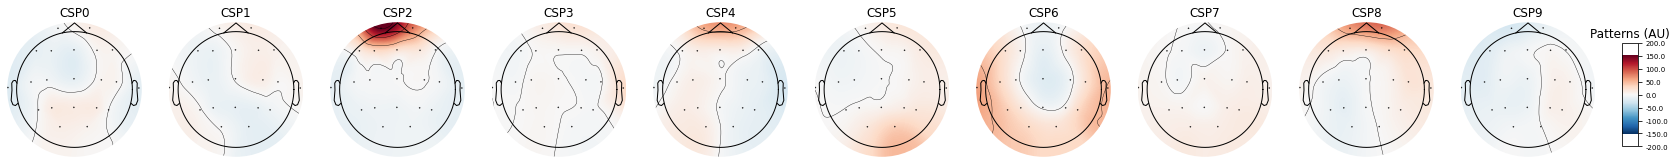




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.49109947643979057


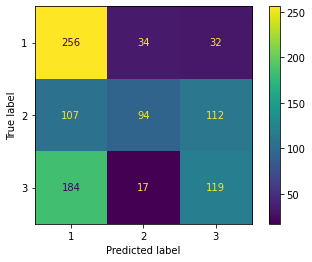

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


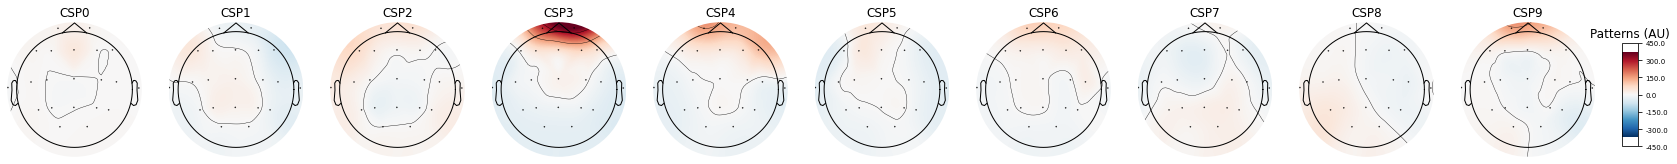

In [6]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
best_found_csp_components = [10, 10 , 10]
best_found_rf_depth = [3, None, 10]
best_found_rf_max_featues = [0.4, 0.2, 0.4]
best_found_rf_min_sample = [10, 2, 10]
best_found_rf_n_estimators = [500, 50, 250]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    ################# TRAINING DATA #################
    with io.capture_output():
        # Get all training data (all but last session of participant)
        mne_raws = CLA_dataset.get_all_but_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Combine training data into singular mne raw
        mne_raw = mne.concatenate_raws(mne_raws)
        
        # Get epochs for all those MNE raws (all training sessions)
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_train = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_train = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raws
        del mne_raw
        del mne_epochs
    
    ################# TESTING DATA #################
    with io.capture_output():
        # Get test data
        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i])
        
        # Get epochs for test MNE raw
        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                             start_offset= start_offset,
                                                             end_offset= end_offset,
                                                             baseline= baseline)
        
        # Only keep epochs from the MI tasks
        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']

        # Load epochs into memory
        mne_epochs.load_data()
        
        # Get the labels
        y_test = mne_epochs.events[:, -1]
        
        # Use a fixed filter
        mne_epochs.filter(l_freq= filter_lower_bound,
                          h_freq= filter_upper_bound,
                          picks= "all",
                          phase= "minimum",
                          fir_window= "blackman",
                          fir_design= "firwin",
                          pad= 'median', 
                          n_jobs= -1,
                          verbose= False)

        # Get a half second window
        X_test = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
        
        # Delete resedual vars for training data
        del mne_raw
        del mne_epochs
    
    ################# FIT AND PREDICT #################
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    rf = RandomForestClassifier(bootstrap= True,
                                criterion= "gini",
                                max_depth= best_found_rf_depth[i],
                                max_features= best_found_rf_max_featues[i],
                                min_samples_split= best_found_rf_min_sample[i],
                                n_estimators= best_found_rf_n_estimators[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('RF', rf)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_rf_depth
del best_found_rf_max_featues
del best_found_rf_min_sample
del best_found_rf_n_estimators
del i
del X_test
del y_test
del X_train
del y_train
del csp
del rf
del pipeline
del y_pred
del accuracy
del start_offset
del end_offset
del baseline
del filter_lower_bound
del filter_upper_bound

<hr><hr>

## New subject

TODO

In [ ]:
# TODO: foresee as needed in paper.

<hr><hr>

## Getting favourable results with CSP

TODO

In [ ]:
# TODO: foresee as needed in paper

<hr><hr>

## Cleaning residual notebook variables

This last codeblock cleans any resedual notebook variables.

In [ ]:
####################################################
# CLEAN NOTEBOOK VARIABLES
####################################################
